In [1]:
from sklearn import datasets
(X, y) = datasets.make_moons(n_samples=1000)
(X_tst, y_tst) = datasets.make_moons(n_samples=1000)

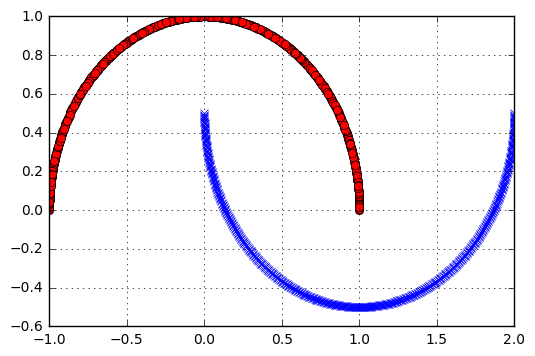

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(X[(y==0), 0], X[(y==0), 1], 'or')
plt.plot(X[(y==1), 0], X[(y==1), 1], 'xb')
plt.grid()

In [103]:
import numpy as np
y = y.astype(np.float32).reshape(-1, 1)

In [182]:
import tensorflow as tf

In [183]:
X_tf = tf.placeholder(tf.float32, [None, 2])

In [184]:
W1 = tf.Variable(np.random.randn(2, 4)*0.01, dtype=tf.float32)
b1 = tf.Variable(np.ones([4])*0.01, dtype=tf.float32)

In [185]:
h = tf.nn.tanh(tf.matmul(X_tf, W) + b)

In [186]:
w_o = tf.Variable(np.random.randn(4, 1)*0.01, dtype=tf.float32)
b_o = tf.Variable([0.01], dtype=tf.float32)

In [187]:
f = tf.nn.sigmoid(tf.matmul(h, w_o) + b_o)

In [188]:
y_tf = tf.placeholder(tf.float32, [None, 1])

In [189]:
loss = - tf.reduce_sum(y_tf*tf.log(f) + (1.0-y_tf)*tf.log(1.0 - f))

In [190]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [201]:
train_step = tf.train.MomentumOptimizer(learning_rate=0.01, momentum=0.9).minimize(loss)

In [202]:
sess = tf.InteractiveSession()

In [203]:
tf.global_variables_initializer().run()

In [204]:
epochs = 150
batch_size = 10
loss_history = np.zeros(epochs)

In [205]:
for i in range(epochs):
    loss_history[i] = sess.run(loss, feed_dict={X_tf: X, y_tf: y})
    for xs, ys in iterate_minibatches(X, y, batch_size):
        sess.run(train_step, feed_dict={X_tf: xs, y_tf: ys})

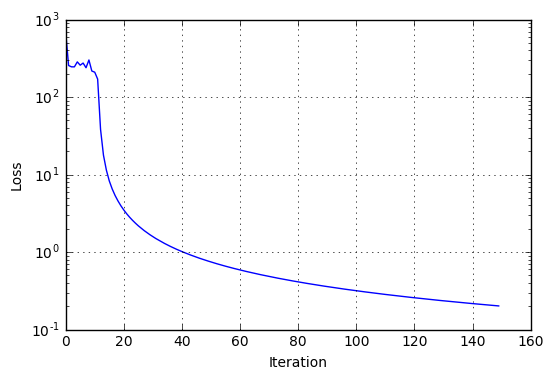

In [284]:
plt.figure()
plt.semilogy(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid()

In [207]:
from sklearn import metrics
y_pred = np.round(sess.run(f, feed_dict={X_tf: X_tst}))
print('Final accuracy is: ', metrics.accuracy_score(y_tst, y_pred))

Final accuracy is:  1.0


In [208]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

In [209]:
Z = sess.run(f, feed_dict={X_tf:np.c_[xx.ravel(), yy.ravel()]}) 

TypeError: unhashable type: 'slice'

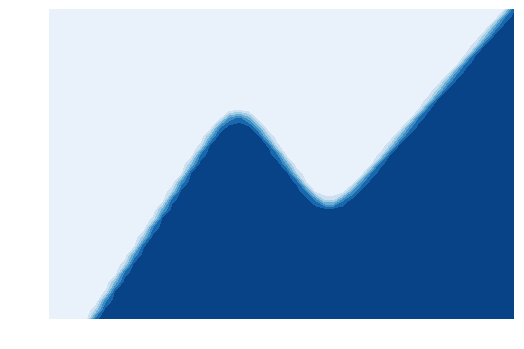

In [283]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues)
plt.axis('off')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)

http://download.tensorflow.org/data/iris_training.csv
http://download.tensorflow.org/data/iris_test.csv

In [243]:
training_set = tf.contrib.learn.datasets.base.load_csv_with_header(
      filename='../../../Downloads/iris_training.csv',
      target_dtype=np.int,
      features_dtype=np.float32)

In [268]:
# Sepal Length, Sepal Width, Petal Length and Petal Width
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=4)]

In [269]:
classifier = tf.contrib.learn.DNNClassifier(feature_columns=feature_columns,
                                              hidden_units=[10, 5],
                                              n_classes=3,
                                              model_dir="/tmp/iris_model")

In [275]:
tf.logging.set_verbosity(tf.logging.FATAL)

In [276]:
def get_train_inputs():
    x = tf.constant(training_set.data)
    y = tf.constant(training_set.target)

    return x, y

In [277]:
# Fit model.
classifier.fit(input_fn=get_train_inputs, steps=2000)

DNNClassifier(params={'input_layer_min_slice_size': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'activation_fn': <function relu at 0x000000000A96D268>, 'hidden_units': [10, 5], 'head': <tensorflow.contrib.learn.python.learn.estimators.head._MultiClassHead object at 0x0000000015DF6470>, 'feature_columns': (_RealValuedColumn(column_name='', dimension=4, default_value=None, dtype=tf.float32, normalizer=None),), 'optimizer': None, 'dropout': None})

In [278]:
test_set = tf.contrib.learn.datasets.base.load_csv_with_header(
      filename='../../../Downloads/iris_test.csv',
      target_dtype=np.int,
      features_dtype=np.float32)

In [279]:
def get_test_inputs():
    x = tf.constant(test_set.data)
    y = tf.constant(test_set.target)

    return x, y

In [280]:
# Evaluate accuracy.
accuracy_score = classifier.evaluate(input_fn=get_test_inputs,
                                     steps=1)["accuracy"]

print("\nTest Accuracy: {0:f}\n".format(accuracy_score))


Test Accuracy: 0.966667

